# Model Building

In [1]:
# Import libraries
import pandas as pd
import boto3
import sagemaker
from pyathena import connect
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from time import gmtime, strftime, sleep
from sagemaker.model import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [12]:
# View created feature groups
!aws sagemaker list-feature-groups

{
    "FeatureGroupSummaries": [
        {
            "FeatureGroupName": "foodlens-products-feature-group-11-21-18-59",
            "FeatureGroupArn": "arn:aws:sagemaker:us-east-1:243285667099:feature-group/foodlens-products-feature-group-11-21-18-59",
            "CreationTime": 1760217539.364,
            "FeatureGroupStatus": "Created",
            "OfflineStoreStatus": {
                "Status": "Active"
            }
        }
    ]
}


In [13]:
# Change this to your feature group (ex. "foodlens-products-feature-group-30-14-49-50")
# feature_group_name = None
feature_group_name = "foodlens-products-feature-group-30-14-49-50"
assert feature_group_name is not None

In [4]:
# Initialize SageMaker session and Feature Group
# Setup boto and sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sess)
prefix = "nutriscore-prediction-xgboost"

# Initialize athena query staging
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create connection to Athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [16]:
import boto3
sm_client = boto3.client('sagemaker', region_name=region)

response = sm_client.list_feature_groups()
for fg in response['FeatureGroupSummaries']:
    print(fg['FeatureGroupName'], "|", fg['FeatureGroupStatus'])


foodlens-products-feature-group-11-21-18-59 | Created


In [17]:
from sagemaker.feature_store.feature_group import FeatureGroup
import sagemaker

# Use the existing Feature Group name
feature_group_name = "foodlens-products-feature-group-11-21-18-59"

# Connect to SageMaker Feature Store
session = sagemaker.Session()
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=session)

# Describe feature group and get key attributes
record_id_name = feature_group.describe()['RecordIdentifierFeatureName']
query = feature_group.athena_query()
table_name = query.table_name

print(f"Athena Table Name: {table_name}")
print(f"Record Identifier: {record_id_name}")


Athena Table Name: foodlens_products_feature_group_11_21_18_59_1760217539
Record Identifier: code


In [18]:
# Verify 100k unique records in feature store
statement = """SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.{}""".format(table_name)
print(statement)
df = pd.read_sql(statement, conn)
df

SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.foodlens_products_feature_group_11_21_18_59_1760217539


/tmp/ipykernel_756/3127886201.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,_col0
0,100000


## Prepare Dataset Splits

In [7]:
# Split data into training/testing/validation/production sets

# Base query template
# We use xxhash64 for its speed. It creates a deterministic hash for each record ID.
query_template = f"""
SELECT *
FROM "{table_name}"
WHERE MOD(ABS(from_big_endian_64(xxhash64(CAST("{record_id_name}" AS VARBINARY)))), 100)
"""

# --- Training Data (40%) ---
train_query_string = query_template + " BETWEEN 0 AND 39"
train_query = feature_group.athena_query()
train_query.run(query_string=train_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/train/')
train_query.wait()
train_df = train_query.as_dataframe(dtype={0: str}) # code col as str

# --- Production Data (40%) ---
prod_query_string = query_template + " BETWEEN 40 AND 79"
prod_query = feature_group.athena_query()
prod_query.run(query_string=prod_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/prod/')
prod_query.wait()
prod_df = prod_query.as_dataframe()

# --- Test Data (10%) ---
test_query_string = query_template + " BETWEEN 80 AND 89"
test_query = feature_group.athena_query()
test_query.run(query_string=test_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/test/')
test_query.wait()
test_df = test_query.as_dataframe()

# --- Validation Data (10%) ---
validation_query_string = query_template + " BETWEEN 90 AND 99"
validation_query = feature_group.athena_query()
validation_query.run(query_string=validation_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/validation/')
validation_query.wait()
val_df = validation_query.as_dataframe()

# Verify the shapes of the resulting DataFrames
print(f"Training set shape:   {train_df.shape}")
print(f"Production set shape: {prod_df.shape}")
print(f"Test set shape:       {test_df.shape}")
print(f"Validation set shape: {val_df.shape}")

Training set shape:   (39955, 30)
Production set shape: (39992, 30)
Test set shape:       (9962, 30)
Validation set shape: (10091, 30)


In [20]:
# View training data samples
pd.set_option('display.max_columns', None)
train_df.head(3)

,code,product_name,nova_group,additives_n,ingredients_n,nutriscore_score,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,nutrition_score_fr_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g,eventtime,write_time,api_invocation_time,is_deleted
0,0041163497511,Rotisserie Chicken,4,1,16,-1,991.0,0.00166,0.00,0.118,0.000665,0.0,1.458333,0.00,4.85,0.0,15.2,24.90,1.458333,237.0,4.0,-1.0,0.000000,0.000001,0.000055,0.000,1.760218e+09,2025-10-11 21:33:13.233,2025-10-11 21:28:16.000,False
1,0053760460485,Artichoke hearts 5-7 ct,3,1,4,-2,126.0,0.65000,6.00,0.000,0.260000,2.0,85.288216,1.00,0.00,0.0,0.0,1.00,85.288216,30.0,3.0,-2.0,0.000000,0.000360,0.040000,0.000,1.760218e+09,2025-10-11 21:33:13.233,2025-10-11 21:28:16.000,False
2,0070980040990,Spears All Green Asparagus,3,0,3,-2,71.0,0.76000,2.61,0.000,0.304000,0.9,85.465580,2.61,0.00,0.0,0.0,1.74,85.465580,17.0,3.0,-2.0,0.000078,0.000310,0.000000,0.013,1.760218e+09,2025-10-11 21:33:13.233,2025-10-11 21:28:16.000,False


## Data Preprocessing

In [8]:
# Feature selection
target = 'nutriscore_score'
cols_to_drop = [
    target,
    'code',
    'product_name',
    'nutrition_score_fr_100g', # data leakage
    'eventtime',
    'write_time',
    'api_invocation_time',
    'is_deleted']

# Set training data
y_train = train_df[target]
X_train = train_df.drop(columns=cols_to_drop)

# Set testing data
y_test = test_df[target]
X_test = test_df.drop(columns=cols_to_drop)

# Set validation data
y_val = val_df[target]
X_val = val_df.drop(columns=cols_to_drop)

# Set production data
y_prod = prod_df[target]
X_prod = prod_df.drop(columns=cols_to_drop)

# View filtered training data
X_train.head()

,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,...,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,2,0,1,3586.0,0.0000,0.00,0.000,0.000,1.4,0.000000,...,0.0,100.00,0.00,0.000000,857.1429,2.0,0.000000,0.00071,0.0254,0.0000
1,4,0,11,1071.0,0.9875,44.19,0.000,0.395,4.7,6.081250,...,0.0,1.16,16.28,6.081250,256.0000,4.0,0.000000,0.00251,0.0000,0.0000
2,3,0,22,1029.0,1.2725,29.82,0.053,0.509,1.8,0.000000,...,0.0,8.77,12.28,0.182292,246.0000,3.0,0.000105,0.00189,0.1750,0.0021
3,3,0,27,837.0,0.6400,35.20,0.000,0.256,3.2,46.210075,...,0.0,4.80,4.00,46.210075,200.0000,3.0,0.000000,0.00080,0.0000,0.0000
4,4,0,10,849.0,0.1350,16.22,0.000,0.054,1.4,62.500000,...,0.0,13.51,4.05,100.000000,203.0000,4.0,0.000000,0.00135,0.0530,0.0000


In [9]:
# Perform Standardization scaling for regression (FIT ONLY ON TRAINING DATA)

# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit the pipeline on the training data
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)
X_val_scaled = preprocessing_pipeline.transform(X_val)
X_prod_scaled = preprocessing_pipeline.transform(X_prod)

# View scaled training data samples
print(X_train_scaled[:3])

[[-1.48680851 -0.7667445  -0.96996279  0.90253566 -0.04335877 -0.50553119
  -0.03276853 -0.04334931 -0.16964973 -0.55211701 -0.35814467  1.6634087
  -0.03763313  2.20883776 -0.29564197 -0.65856417  0.90232767 -1.48680851
  -0.00593822 -0.02058298 -0.12551833 -0.07854952]
 [ 0.58094185 -0.7667445  -0.39223475 -0.14427443 -0.02419738  0.04067351
  -0.03276853 -0.02419372  0.17032778 -0.34192241 -0.27290327 -0.39748395
  -0.03763313 -0.39161408  0.24881532 -0.47051196 -0.14445722  0.58094185
  -0.00593822  0.00558683 -0.19263662 -0.07854952]
 [-0.45293333 -0.7667445   0.24326609 -0.16175595 -0.01866726 -0.13694499
   0.01664275 -0.01866527 -0.12844034 -0.55211701 -0.32606458 -0.08082779
  -0.03763313 -0.19139718  0.11504203 -0.65292712 -0.16187047 -0.45293333
  -0.00593342 -0.00342722  0.26979256 -0.04301772]]


In [15]:
# Prepare data splits for upload
# Convert scaled splits back into dataframe.
# We also need to set the target as the first column.
# This is required by the SageMaker XGBoost algorithm.

X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_upload_df = pd.concat([pd.DataFrame(y_train).reset_index(drop=True), X_train_df], axis=1)

X_test_df = pd.DataFrame(X_test_scaled)
test_upload_df = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), X_test_df], axis=1)

X_val_df = pd.DataFrame(X_val_scaled)
val_upload_df = pd.concat([pd.DataFrame(y_val).reset_index(drop=True), X_val_df], axis=1)

X_prod_df = pd.DataFrame(X_prod_scaled)
prod_upload_df = pd.concat([pd.DataFrame(y_prod).reset_index(drop=True), X_prod_df], axis=1)

# View scaled training data samples
train_upload_df.head()

,nutriscore_score,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,...,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,12,-1.486809,-0.766744,-0.969963,0.902536,-0.043359,-0.505531,-0.032769,-0.043349,-0.169650,...,-0.037633,2.208838,-0.295642,-0.658564,0.902328,-1.486809,-0.005938,-0.020583,-0.125518,-0.078550
1,0,0.580942,-0.766744,-0.392235,-0.144274,-0.024197,0.040674,-0.032769,-0.024194,0.170328,...,-0.037633,-0.391614,0.248815,-0.470512,-0.144457,0.580942,-0.005938,0.005587,-0.192637,-0.078550
2,13,-0.452933,-0.766744,0.243266,-0.161756,-0.018667,-0.136945,0.016643,-0.018665,-0.128440,...,-0.037633,-0.191397,0.115042,-0.652927,-0.161870,-0.452933,-0.005933,-0.003427,0.269793,-0.043018
3,2,-0.452933,-0.766744,0.532130,-0.241671,-0.030940,-0.070446,-0.032769,-0.030935,0.015793,...,-0.037633,-0.295847,-0.161869,0.770403,-0.241971,-0.452933,-0.005938,-0.019274,-0.192637,-0.078550
4,2,0.580942,-0.766744,-0.450008,-0.236677,-0.040739,-0.305046,-0.032769,-0.040731,-0.169650,...,-0.037633,-0.066689,-0.160197,2.433764,-0.236747,0.580942,-0.005938,-0.011278,-0.052587,-0.078550


In [16]:
# Upload train data with headers for data monitor
train_file_headers = "train_scaled_headers.csv"
train_upload_df.to_csv(train_file_headers, index=False, header=True)
train_s3_path = sess.upload_data(train_file_headers, key_prefix="{}/train".format(prefix))
print(f"Train data with headers uploaded to: {train_s3_path}")

Train data with headers uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/train/train_scaled_headers.csv


In [100]:
# Upload data files to S3
train_file = "train_scaled.csv"
train_upload_df.to_csv(train_file, index=False, header=False)
train_s3_path = sess.upload_data(train_file, key_prefix="{}/train".format(prefix))
print(f"Train data uploaded to: {train_s3_path}")

test_file = "test_scaled.csv"
test_upload_df.to_csv(test_file, index=False, header=False)
test_s3_path = sess.upload_data(test_file, key_prefix="{}/test".format(prefix))
print(f"Test data uploaded to: {test_s3_path}")

# Upload test file without target col for batch transform later
test_features_only_file = "test_features_only.csv"
test_features_only_df = test_upload_df.drop(columns=[target])
test_features_only_df.to_csv(test_features_only_file, index=False, header=False)
test_features_only_s3_path = sess.upload_data(test_features_only_file, key_prefix="{}/test".format(prefix))
print(f"Test data for batch transform uploaded to: {test_features_only_s3_path}")

val_file = "val_scaled.csv"
val_upload_df.to_csv(val_file, index=False, header=False)
val_s3_path = sess.upload_data(val_file, key_prefix="{}/validation".format(prefix))
print(f"Val data uploaded to: {val_s3_path}")

prod_file = "prod_scaled.csv"
prod_upload_df.to_csv(prod_file, index=False, header=False)
prod_s3_path = sess.upload_data(prod_file, key_prefix="{}/prod".format(prefix))
print(f"Prod data uploaded to: {prod_s3_path}")

Train data uploaded to: s3://sagemaker-us-east-1-243285667099/nutriscore-prediction-xgboost/train/train_scaled.csv
Test data uploaded to: s3://sagemaker-us-east-1-243285667099/nutriscore-prediction-xgboost/test/test_scaled.csv
Test data for batch transform uploaded to: s3://sagemaker-us-east-1-243285667099/nutriscore-prediction-xgboost/test/test_features_only.csv
Val data uploaded to: s3://sagemaker-us-east-1-243285667099/nutriscore-prediction-xgboost/validation/val_scaled.csv
Prod data uploaded to: s3://sagemaker-us-east-1-243285667099/nutriscore-prediction-xgboost/prod/prod_scaled.csv


## Baseline: Training Job and Model Creation

=== Linear Regression Baseline Performance ===
Test Set:       RMSE = 8.194, MAE = 6.414, R² = 0.380
Validation Set: RMSE = 8.220, MAE = 6.427, R² = 0.381

Sample Predictions:
   Actual  Predicted
0      32  15.430192
1       8  15.581833
2      25  18.106018
3       7   7.970983
4      12  13.604631
5      23  15.065139
6      11  13.015403
7      15  15.136650
8      21  17.829565
9      12  14.170134


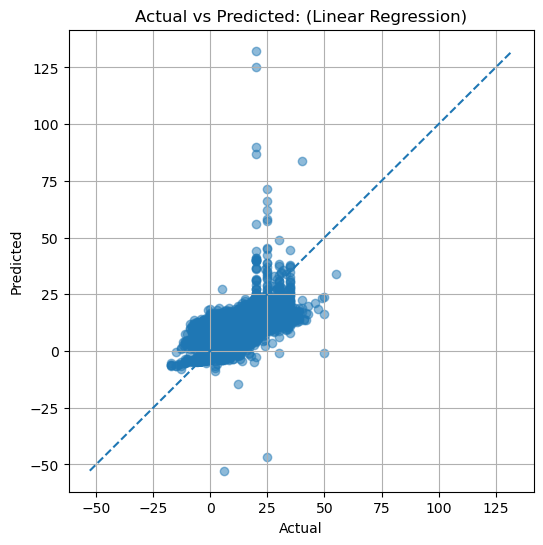

In [30]:
# ---------------------------------------------------------
# Baseline Model: Linear Regression
# ---------------------------------------------------------
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

y_train = np.asarray(y_train).ravel()
y_test  = np.asarray(y_test).ravel()
y_val   = np.asarray(y_val).ravel()

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

y_pred_test = baseline_model.predict(X_test_scaled)
y_pred_val  = baseline_model.predict(X_val_scaled)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Print results
print("=== Linear Regression Baseline Performance ===")
print(f"Test Set:       RMSE = {rmse_test:.3f}, MAE = {mae_test:.3f}, R² = {r2_test:.3f}")
print(f"Validation Set: RMSE = {rmse_val:.3f}, MAE = {mae_val:.3f}, R² = {r2_val:.3f}")

# Sample predictions
comparison_df = pd.DataFrame({
    "Actual": y_test[:10],
    "Predicted": y_pred_test[:10]
})
print("\nSample Predictions:")
print(comparison_df)

# Actual vs Predicted scatter plot for test set
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
maxv = max(np.max(y_test), np.max(y_pred_test))
minv = min(np.min(y_test), np.min(y_pred_test))
plt.plot([minv, maxv], [minv, maxv], linestyle='--') 
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: (Linear Regression)")
plt.grid(True)
plt.show()

## XGBoost: Training Job and Model Creation

In [ ]:
# Create training job
job_name = "nutrition-score-xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

# Specify model
image = sagemaker.image_uris.retrieve(framework="xgboost", region=region, version="1.7-1")
instance_type = 'ml.m5.xlarge'
model_name = job_name

# Set estimator
sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type=instance_type,
    output_path=output_location,
    sagemaker_session=sess,
)

# Set hyperparameters for regression
sm_estimator.set_hyperparameters(
    objective="reg:squarederror",
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    num_round=100,
)

# Set input locations for train and val sets
train_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train", content_type="text/csv"
)
val_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validation", content_type="text/csv"
)
data_channels = {"train": train_data, "validation": val_data}

# Launch training job
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker:Creating training-job with name: nutrition-score-xgb-2025-10-11-21-42-11


2025-10-11 21:42:11 Starting - Starting the training job...
2025-10-11 21:42:36 Starting - Preparing the instances for training...
2025-10-11 21:42:58 Downloading - Downloading input data..

## Batch Transform Job for Test Predictions

In [101]:
# Create transformer object from trained estimator
transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type=instance_type
)

# Start the batch transform job
transformer.transform(
    data=test_features_only_s3_path,
    content_type='text/csv'
)

# Wait for the job to complete
print("Batch Transform job started. Waiting for completion...")
transformer.wait()
print("Job complete.")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-10-09-02-01-33-796
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-10-09-02-01-34-510


............................./miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-10-09:02:06:25:INFO] No GPUs detected (normal if no gpus installed)
[2025-10-09:02:06:25:INFO] No GPUs detected (normal if no gpus installed)
[2025-10-09:02:06:25:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invoc

## Compare Model Performance

In [111]:
# Calculate performance on test set

# S3 location of the prediction results
output_s3_path = transformer.output_path

# Download the prediction results into a pandas DataFrame
predictions_df = pd.read_csv(f"{output_s3_path}/{test_features_only_file}.out", header=None)
predictions_df

,0
0,1.043224
1,-0.562068
2,18.242599
3,21.298990
4,18.299925
...,...
9957,3.661992
9958,14.841149
9959,32.303715
9960,8.007389


In [112]:
# Calculate performance metrics
predictions = predictions_df[0]
rmse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"XGBoost Model Performance:")
print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")
print(f"R²:   {r2}")

XGBoost Model Performance:
RMSE: 3.327843795615383
MAE:  1.0611442705088197
R²:   0.9692863623696583


In [ ]:
# Compare baseline RMSE to XGBoost RMSE
# print metrics of both models on test set
# print metrics of baseline
# print metrics of xgboost

Some comparison discussion on test results... 

## Upload Trained XGBoost Model to SageMaker Model Registry

In [67]:
# Initialize the sagemaker client
sagemaker_client = boto3.client("sagemaker")

# Get the S3 path to the trained model artifacts
info = sagemaker_client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model artifacts are located at: {model_data}")

# Define the container image for inference (we defined 'image' earlier)
primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save model to Sagemaker Model Registry
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print(f"\nSuccessfully created model: {create_model_response['ModelArn']}")

Model artifacts are located at: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/output/nutrition-score-xgb-2025-10-09-00-49-00/nutrition-score-xgb-2025-10-09-00-49-00/output/model.tar.gz

Successfully created model: arn:aws:sagemaker:us-east-1:654654380268:model/nutrition-score-xgb-2025-10-09-00-49-00


In [ ]:
# View model name
model_name